### Task 1: Data preparation and customer analytics

Conduct analysis on your client's transaction dataset and identify customer purchasing behaviours to generate insights and provide commercial recommendations.

We need to present a strategic recommendation to Julia the Category Manager for chips, which is supported by data that she can use for the upcoming category review. To do so we need to analyse the data to understand the current purchasing trends and behaviours. The client is particularly interested in customer segments and their chip purchasing behaviour. Consider what metrics would help describe the customers’ purchasing behaviour. 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Exploratory Data Analysis

The first step in the analysis is to understand the data. Let's take a look at the datasets that were provided.


In [10]:
pr_bhv = pd.read_csv("QVI_purchase_behaviour.csv")
pr_bhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
LYLTY_CARD_NBR      72637 non-null int64
LIFESTAGE           72637 non-null object
PREMIUM_CUSTOMER    72637 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [11]:
pr_bhv.columns

Index(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER'], dtype='object')

In [12]:
tr_data = pd.read_excel("QVI_transaction_data.xlsx")
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
DATE              264836 non-null int64
STORE_NBR         264836 non-null int64
LYLTY_CARD_NBR    264836 non-null int64
TXN_ID            264836 non-null int64
PROD_NBR          264836 non-null int64
PROD_NAME         264836 non-null object
PROD_QTY          264836 non-null int64
TOT_SALES         264836 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


#### We can see that the "DATE" column is in int64 format. Let's change it to datetime format. A quick online search tells us that integer dates begin from 1899,12,30.

In [13]:
from datetime import date, timedelta
start = date(1899,12,30)

new_date_format = []

for date in tr_data["DATE"]:
    delta = timedelta(date)
    new_date_format.append(start + delta)
    
pd.Series(new_date_format)
    
tr_data["DATE"] = pd.to_datetime(new_date_format)


In [14]:
print(tr_data["DATE"].dtype)
tr_data["DATE"].head(3)

datetime64[ns]


0   2018-10-17
1   2019-05-14
2   2019-05-20
Name: DATE, dtype: datetime64[ns]

#### We should check whether we are looking at the right products by examining the product name.

In [15]:
tr_data["PROD_NAME"].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [16]:
## Replacing non-word characters like &, / with empty space and removing the numbers as that's not important
split_prods = tr_data["PROD_NAME"].str.replace(r'([0-9]+[gG])','').str.replace(r'[^\w]', ' ').str.split()
split_prods.head(10)

0             [Natural, Chip, Compny, SeaSalt]
1                         [CCs, Nacho, Cheese]
2       [Smiths, Crinkle, Cut, Chips, Chicken]
3      [Smiths, Chip, Thinly, S, Cream, Onion]
4    [Kettle, Tortilla, ChpsHny, Jlpno, Chili]
5    [Old, El, Paso, Salsa, Dip, Tomato, Mild]
6      [Smiths, Crinkle, Chips, Salt, Vinegar]
7                [Grain, Waves, Sweet, Chilli]
8     [Doritos, Corn, Chip, Mexican, Jalapeno]
9          [Grain, Waves, Sour, Cream, Chives]
Name: PROD_NAME, dtype: object

In [17]:
split_prods.head(2)

0    [Natural, Chip, Compny, SeaSalt]
1                [CCs, Nacho, Cheese]
Name: PROD_NAME, dtype: object

In [18]:
words_count = {}

def words_countt(line):
    for words in line:
        if words not in words_count:
            words_count[words] = 1
        else:
            words_count[words] += 1

split_prods.apply(lambda line: words_countt(line))
print(pd.Series(words_count).sort_values(ascending=False).head(20))


Chips       49770
Kettle      41288
Smiths      28860
Salt        27976
Cheese      27890
Pringles    25102
Doritos     24962
Crinkle     23960
Corn        22063
Original    21560
Cut         20754
Chip        18645
Chicken     18577
Salsa       18094
Cream       16926
Chilli      15390
Sea         14145
Thins       14075
Sour        13882
Crisps      12607
dtype: int64


#### There are salsa products in our list but we are only interested in chips. So let's only select products that are not salsa.

In [19]:
salsa_mask = tr_data["PROD_NAME"].str.contains(r"[sS]alsa")

tr_data = tr_data[~salsa_mask]

tr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 8 columns):
DATE              246742 non-null datetime64[ns]
STORE_NBR         246742 non-null int64
LYLTY_CARD_NBR    246742 non-null int64
TXN_ID            246742 non-null int64
PROD_NBR          246742 non-null int64
PROD_NAME         246742 non-null object
PROD_QTY          246742 non-null int64
TOT_SALES         246742 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.9+ MB


### Finding anomalies

In [20]:
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 8 columns):
DATE              246742 non-null datetime64[ns]
STORE_NBR         246742 non-null int64
LYLTY_CARD_NBR    246742 non-null int64
TXN_ID            246742 non-null int64
PROD_NBR          246742 non-null int64
PROD_NAME         246742 non-null object
PROD_QTY          246742 non-null int64
TOT_SALES         246742 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.9+ MB


In [21]:
tr_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


#### Seems like product quantity needs to be investigated.

In [22]:
tr_data[tr_data["PROD_QTY"] > 10]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [23]:
tr_data[tr_data["LYLTY_CARD_NBR"] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [24]:
tr_data.drop(labels=tr_data[tr_data["LYLTY_CARD_NBR"] == 226000].index, inplace=True)

In [25]:
tr_data["DATE"].describe()

count                  246740
unique                    364
top       2018-12-24 00:00:00
freq                      865
first     2018-07-01 00:00:00
last      2019-06-30 00:00:00
Name: DATE, dtype: object

### There's a day's transaction data missing.

In [26]:
pd.date_range(start=tr_data["DATE"].min(), end=tr_data["DATE"].max()).difference(tr_data["DATE"])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [27]:
tr_data.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9


In [28]:
check_null_date = pd.merge(pd.Series(pd.date_range(start=tr_data["DATE"].min(), end=tr_data["DATE"].max()), name="DATE").to_frame(), tr_data, on="DATE", how="left")

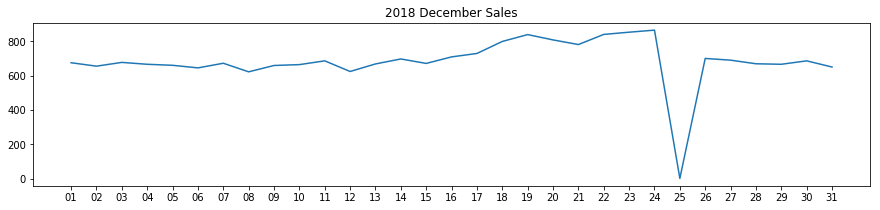

In [29]:
trans_by_date = check_null_date["DATE"].value_counts()
dec = trans_by_date[(trans_by_date.index >= pd.datetime(2018,12,1)) & (trans_by_date.index < pd.datetime(2019,1,1))].sort_index()
dec.index = dec.index.strftime('%d')
ax = dec.plot(figsize=(15,3))
ax.set_xticks(np.arange(len(dec)))
ax.set_xticklabels(dec.index)
plt.title("2018 December Sales")
plt.savefig("2018 December Sales.png", bbox_inches="tight")
plt.show()

### As the missing date falls on Christmas day when the store is closed, this is not an anomaly.

In [30]:
t = tr_data["PROD_NAME"].str.replace(r'[0-9]+(G)','g')
t.head(20)

0       Natural Chip        Compny SeaSalt175g
1                     CCs Nacho Cheese    175g
2       Smiths Crinkle Cut  Chips Chicken 170g
3       Smiths Chip Thinly  S/Cream&Onion 175g
4     Kettle Tortilla ChpsHny&Jlpno Chili 150g
6     Smiths Crinkle Chips Salt & Vinegar 330g
7        Grain Waves         Sweet Chilli 210g
8      Doritos Corn Chip Mexican Jalapeno 150g
9           Grain Waves Sour    Cream&Chives g
10    Smiths Crinkle Chips Salt & Vinegar 330g
11       Kettle Sensations   Siracha Lime 150g
12                    Twisties Cheese     270g
13            WW Crinkle Cut      Chicken 175g
14              Thins Chips Light&  Tangy 175g
15                           CCs Original 175g
16                           Burger Rings 220g
17      NCC Sour Cream &    Garden Chives 175g
18     Doritos Corn Chip Southern Chicken 150g
19                    Cheezels Cheese Box 125g
20           Smiths Crinkle      Original 330g
Name: PROD_NAME, dtype: object

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: 0, dtype: float64


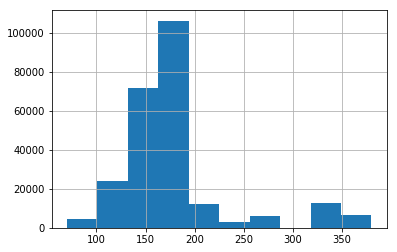

In [31]:
pack_sizes = tr_data["PROD_NAME"].str.extract(r'([0-9]+[gG])')[0].str.replace("[Gg]","").astype(float)
print(pack_sizes.describe())
pack_sizes.hist()

Product size seems reasonable with highest transaction frequency in mid-sized pack. Smallest size is 70g, and largest size is 380g.

Feature Engineering: Creating a new column called "BRAND"

In [32]:
tr_data["PROD_NAME"].str.split().str[0].value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: PROD_NAME, dtype: int64

We can see that some product brands can be written in more than 1 way: Dorito and Doritos, Grain and GrnWves, Infuzions and Infzns, Natural and NCC, Red and RRD, Smith and Smiths, Snbts and Sunbites, WW and Woolworths; suggesting that we merge these information to make analysis more accurate.

In [45]:
tr_data["Cleaned_Brand_Names"] = tr_data["PROD_NAME"].str.split().str[0]
tr_data["Cleaned_Brand_Names"].head(10)

0     Natural
1         CCs
2      Smiths
3      Smiths
4      Kettle
6      Smiths
7       Grain
8     Doritos
9       Grain
10     Smiths
Name: Cleaned_Brand_Names, dtype: object

In [46]:
def clean_brands(line):
    brand = line["Cleaned_Brand_Names"]
    if brand == "Dorito":
        return "Doritos"
    elif brand == "GrnWves" or brand == "Grain":
        return "Grain Waves"
    elif brand == "Infzns":
        return "Infuzions"
    elif brand == "Natural" or brand == "NCC":
        return "Natural Chip Co"
    elif brand == "Red":
        return "RRD"
    elif brand == "Smith":
        return "Smiths"
    elif brand == "Snbts":
        return "Sunbites"
    elif brand == "WW":
        return "Woolworths"
    else:
        return brand    

In [35]:
tr_data["Cleaned_Brand_Names"] = tr_data.apply(lambda line: clean_brands(line), axis=1)



In [36]:
tr_data["Cleaned_Brand_Names"].head(20)

0     Natural Chip Co
1                 CCs
2              Smiths
3              Smiths
4              Kettle
6              Smiths
7         Grain Waves
8             Doritos
9         Grain Waves
10             Smiths
11             Kettle
12           Twisties
13         Woolworths
14              Thins
15                CCs
16             Burger
17    Natural Chip Co
18            Doritos
19           Cheezels
20             Smiths
Name: Cleaned_Brand_Names, dtype: object

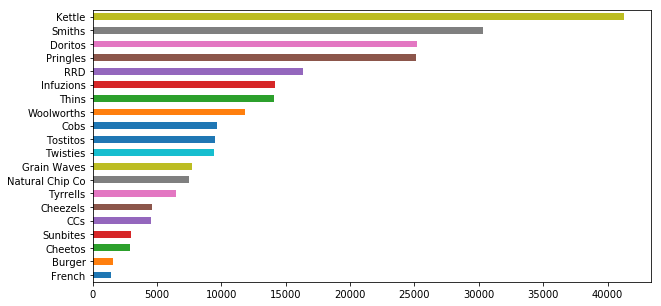

In [37]:
tr_data["Cleaned_Brand_Names"].value_counts(ascending=True).plot.barh(figsize=(10,5))


## Analysing customer purchase behaviour dataset

Some questions to aid our analysis:
1. Which customers spend the most on chips, describing customers by lifestage and how premium is their general purchasing behaviour.
2. Customer Segmentation.
3. How many chips are bought per customer by segment?
4. What's the average chip price by customer segment?

In [38]:
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 264835
Data columns (total 9 columns):
DATE                   246740 non-null datetime64[ns]
STORE_NBR              246740 non-null int64
LYLTY_CARD_NBR         246740 non-null int64
TXN_ID                 246740 non-null int64
PROD_NBR               246740 non-null int64
PROD_NAME              246740 non-null object
PROD_QTY               246740 non-null int64
TOT_SALES              246740 non-null float64
Cleaned_Brand_Names    246740 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 18.8+ MB


In [39]:
print(pr_bhv.info(), "\n")
print(pr_bhv.describe(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
LYLTY_CARD_NBR      72637 non-null int64
LIFESTAGE           72637 non-null object
PREMIUM_CUSTOMER    72637 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None 

       LYLTY_CARD_NBR
count    7.263700e+04
mean     1.361859e+05
std      8.989293e+04
min      1.000000e+03
25%      6.620200e+04
50%      1.340400e+05
75%      2.033750e+05
max      2.373711e+06 



In [40]:
pr_bhv.head(10)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
5,1007,YOUNG SINGLES/COUPLES,Budget
6,1009,NEW FAMILIES,Premium
7,1010,YOUNG SINGLES/COUPLES,Mainstream
8,1011,OLDER SINGLES/COUPLES,Mainstream
9,1012,OLDER FAMILIES,Mainstream


In [41]:
print(pr_bhv["LIFESTAGE"].value_counts(), "\n")
print(pr_bhv["PREMIUM_CUSTOMER"].value_counts())

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64 

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64


### Let's merge the dataframes

In [42]:
merged_data = pd.merge(tr_data, pr_bhv, on="LYLTY_CARD_NBR", how="left")
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 11 columns):
DATE                   246740 non-null datetime64[ns]
STORE_NBR              246740 non-null int64
LYLTY_CARD_NBR         246740 non-null int64
TXN_ID                 246740 non-null int64
PROD_NBR               246740 non-null int64
PROD_NAME              246740 non-null object
PROD_QTY               246740 non-null int64
TOT_SALES              246740 non-null float64
Cleaned_Brand_Names    246740 non-null object
LIFESTAGE              246740 non-null object
PREMIUM_CUSTOMER       246740 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 22.6+ MB


In [43]:
sales_per_group = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].agg(["sum", "mean"])
sales_per_group.head(15)
sales_per_group.sort_values(ascending=False, by="sum")


sum      mean
LIFESTAGE              PREMIUM_CUSTOMER                     
OLDER FAMILIES         Budget            156863.75  7.291241
YOUNG SINGLES/COUPLES  Mainstream        147582.20  7.551279
RETIREES               Mainstream        145168.95  7.269352
YOUNG FAMILIES         Budget            129717.95  7.302705
OLDER SINGLES/COUPLES  Budget            127833.60  7.444305
                       Mainstream        124648.50  7.306049
                       Premium           123537.55  7.459997
RETIREES               Budget            105916.30  7.445786
OLDER FAMILIES         Mainstream         96413.55  7.281440
RETIREES               Premium            91296.65  7.461315
YOUNG FAMILIES         Mainstream         86338.25  7.226772
MIDAGE SINGLES/COUPLES Mainstream         84734.25  7.637156
YOUNG FAMILIES         Premium            78571.70  7.285951
OLDER FAMILIES         Premium            75242.60  7.232779
YOUNG SINGLES/COUPLES  Budget             57122.10  6.663023
MIDAGE SINGLES/COUPLES Premium            54443.85  7.152371
YOUNG SINGLES/COUPLES  Premium            39052.30  6.673325
MIDAGE SINGLES/COUPLES Budget             33345.70  7.108442
NEW FAMILIES           Budget             20607.45  7.297256
                       Mainstream         15979.70  7.313364
                       Premium            10760.80  7.231720

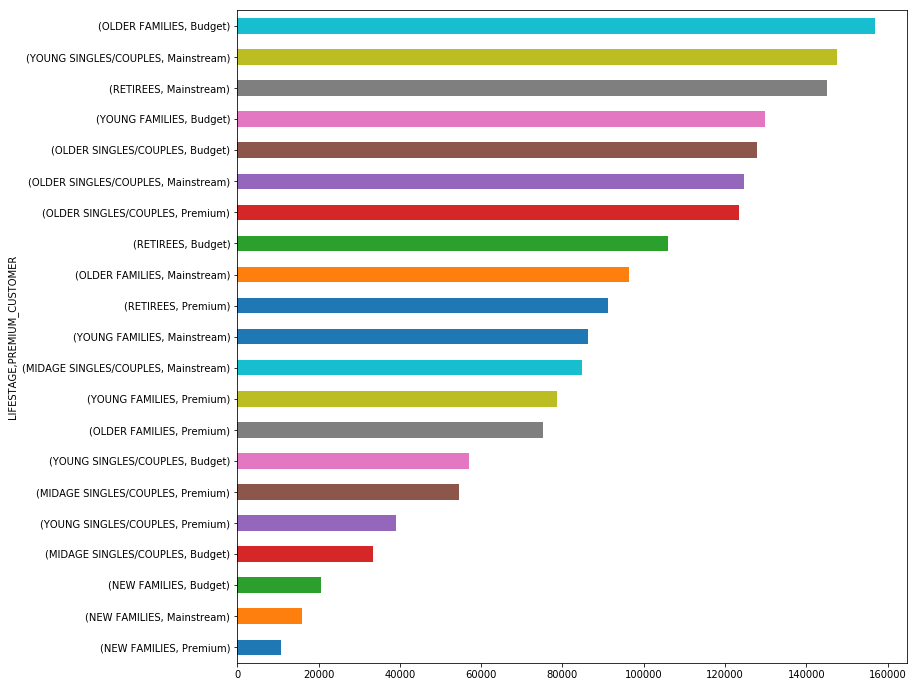

In [44]:
sales_per_group["sum"].sort_values().plot.barh(figsize=(12,12))